In [8]:
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [9]:
# grid_results = pd.read_hdf('models/logreg_gridsearch_results_v2.h5')
grid_model = load("models/logreg_gridsearch_model_11splits.joblib")

In [10]:
grid_results = pd.DataFrame(grid_model.cv_results_)
best = grid_results.iloc[grid_model.best_index_,:]
best.params

{'clf__C': 0.46415888336127775,
 'clf__max_iter': 10000,
 'clf__penalty': 'l1',
 'clf__solver': 'saga',
 'qt__n_quantiles': 10,
 'qt__output_distribution': 'normal'}

In [16]:
# get the avg score for the splits on subjects where AT was applied
at_columns = grid_results.columns[grid_results.columns.str.match('split[0-4]_test_F1-score')]
grid_results['mean_AT_F1-score'] = grid_results[at_columns].mean(axis=1)

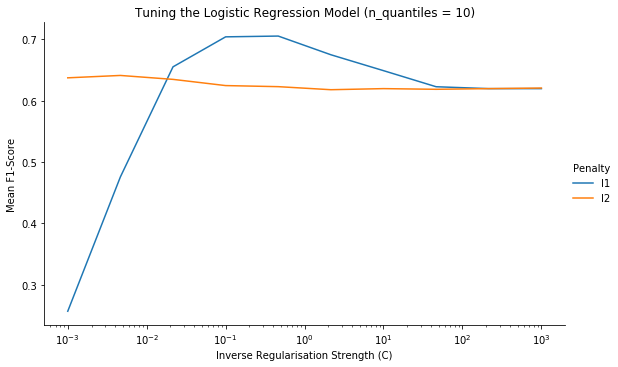

In [15]:
# visualise the best penalty
fg = sns.FacetGrid(data = grid_results, hue='param_clf__penalty', aspect=1.61, height=5)
fg.map(plt.semilogx, 'param_clf__C', 'mean_test_F1-score').add_legend(title='Penalty')
fg.set(xlabel='Inverse Regularisation Strength (C)', ylabel='Mean F1-Score', title='Tuning the Logistic Regression Model (n_quantiles = 10)')
# fg.savefig('reports/figures/logreg_grid_penalty_qt_10_AUC')

In [13]:
grid_results.sort_values('mean_AT_F1-score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__max_iter,param_clf__penalty,param_clf__solver,param_qt__n_quantiles,param_qt__output_distribution,...,split5_test_Recall,split6_test_Recall,split7_test_Recall,split8_test_Recall,split9_test_Recall,split10_test_Recall,mean_test_Recall,std_test_Recall,rank_test_Recall,mean_AT_F1-score
8,344.005642,60.754480,2.732299,0.059155,0.464159,10000,l1,saga,10,normal,...,0.900000,0.850000,0.566667,0.766667,0.900000,0.866667,0.740909,0.156280,2,0.600142
6,215.445306,68.884234,2.726808,0.091035,0.1,10000,l1,saga,10,normal,...,0.883333,0.900000,0.516667,0.766667,0.950000,0.866667,0.743939,0.157909,1,0.595212
10,360.689686,37.035535,2.719279,0.064380,2.15443,10000,l1,saga,10,normal,...,0.850000,0.783333,0.583333,0.700000,0.900000,0.750000,0.711111,0.138292,3,0.591341
12,316.801860,44.303328,2.709077,0.051912,10,10000,l1,saga,10,normal,...,0.850000,0.750000,0.616667,0.666667,0.900000,0.716667,0.693939,0.143772,4,0.551059
3,8.441166,1.066295,2.730424,0.038583,0.00464159,10000,l2,saga,10,normal,...,0.850000,0.866667,0.550000,0.616667,0.883333,0.733333,0.687879,0.157453,5,0.544127


In [17]:
# refit the model using best params
# do one for l2 and one for l1
X = pd.read_hdf('data/features/filtered/filtered_0.05_.h5')
y = pd.read_hdf('data/ach_at_combined_y.h5', key='y')

s = 1
for i in range(1,6):
    X.loc[90*(i-1):90*i,'subject'] = s
    s += 1
for i in range(1,7):
    X.loc[450+(60*(i-1)):450+(60*i),'subject'] = s
    s+=1
assert not any(pd.isna(X['subject']))

# USE SUBJECT 4 AS A TEST
train = X[X['subject'] != 4].index
test = X[X['subject'] == 4].index

X_train, X_test, y_train, y_test = X.iloc[train,:], X.iloc[test,:], y.iloc[train], y.iloc[test]

In [18]:
best_l1_model = Pipeline(steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=10,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('clf',
                 LogisticRegression(C=0.46415888336127775, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1',
                                    random_state=None, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)
best_l1_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=10,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('clf',
                 LogisticRegression(C=0.46415888336127775, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1',
                                    random_state=None, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [206]:
y_pred = best_l1_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[29  0  0]
 [ 0 30  0]
 [ 0  0 31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        31

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [ ]:
splits = []
for i in range(0,11):
    split = best[[col for col in best if col.startswith('split'+str(i)+'_test')]]
    split.columns = split.columns.str.lstrip('split'+str(i)+'_test_')
    split.index = [i]
    splits.append(split)

scores = pd.concat(splits)
scores['test_subject'] = scores.index+1
sns.set_style(style="whitegrid")
scores2 = pd.melt(scores, id_vars='test_subject', value_vars=['F1-score'],
var_name='metric',value_name='score')
g = sns.catplot(
    data = scores2, kind = 'bar',
    x = 'test_subject', y='score', hue='metric',
    ci="sd", palette="dark", alpha=.6, height=6
)
plt.show()

In [ ]:
# try removing some of the subjects
# WORST - 2,8,1

